# Weather Forecasting with Transformer (Hourly Data)

This notebook builds a strictly chronological dataset and trains several sequence models to predict **tomorrow's** maximum temperature (`TMAX`). We make **one prediction per day at midnight**, using the previous 30 days (720 hours) of features. Guardrails:
- `dailies.csv` is **target-only**; no daily fields are used as inputs.
- Features come from hourly (or finer) providers: Open Meteo, NASA Power, NOAA LCD, IEM ASOS, Meteostat, and NOAA ISD.
- Daily targets are shifted +1 day so midnight of day *D* maps to day *D+1* TMAX.
- Imputations are forward-looking only (no backfill); daily aggregates are not used as features.

## 1. Imports and Configuration

In [1]:
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cu126

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
!nvidia-smi

Tue Dec  2 04:12:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.07             Driver Version: 581.80         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        On  |   00000000:01:00.0  On |                  N/A |
| 32%   36C    P0             32W /  170W |     508MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# !pip install -r requirements.txt

In [5]:
import os
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Configuration
DATA_ROOT = "data"
LOCATION = "miami_fl"  # change to switch sit
SEQUENCE_LENGTH_DAYS = 30
HOURS_PER_DAY = 24
SEQUENCE_LENGTH = SEQUENCE_LENGTH_DAYS * HOURS_PER_DAY  # 720 hours
PREDICTION_HORIZON_DAYS = 1  # predict next-day TMAX
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 30
TARGET_COLUMN = "target_tmax_next_day"

# Robust loss settings (penalize large absolute errors in degrees)
LOSS_MARGIN_DEG = 0.5   # tolerance before harsh penalty kicks in
LOSS_HARD_PENALTY = 2.0  # weight for errors beyond the margin

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {DEVICE}")
print(f"Sequence Length: {SEQUENCE_LENGTH} hours")


Using device: cuda
Sequence Length: 720 hours


### Provider & Feature Selection

In [6]:
# Select which providers and features to include (set to None to keep all)
USE_PROVIDERS = [
    'Open Meteo',
    'NASA Power',
    # 'NOAA LCD',
    'IEM ASOS',
    'Meteostat',
    # 'NOAA ISD',
]

# Optional per-provider feature whitelist; keep empty dict to include all features per provider
PROVIDER_FEATURES = {
    # 'Open Meteo': ['om_temp', 'om_humidity'],
}

PROVIDER_PREFIX = {
    'om_': 'Open Meteo',
    'np_': 'NASA Power',
    'nl_': 'NOAA LCD',
    'ia_': 'IEM ASOS',
    'ms_': 'Meteostat',
    'isd_': 'NOAA ISD',
}


## 2. Data Ingestion (Hourly)

We load data and align everything to a common hourly index, renaming columns to the standard format.

In [7]:
def load_raw_csvs(pattern):
    files = glob.glob(pattern, recursive=True)
    if not files:
        print(f"Warning: No files found for pattern {pattern}")
        return pd.DataFrame()
    dfs = [pd.read_csv(f) for f in files]
    return pd.concat(dfs, ignore_index=True)


def to_utc_naive(df, ts_col):
    df[ts_col] = pd.to_datetime(df[ts_col], utc=True, errors="coerce").dt.tz_convert(None)
    return df.dropna(subset=[ts_col])


def describe_df(name, df):
    if df is None or df.empty:
        print(f"{name}: empty")
        return
    print(
        f"{name}: shape={df.shape}, cols={len(df.columns)}, start={df.index.min()}, end={df.index.max()}, "
        f"mean NA%={df.isna().mean().mean()*100:.2f}%"
    )


def process_dailies_for_target():
    path = os.path.join(DATA_ROOT, "dailies.csv")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Base dailies not found at {path}")
    df = pd.read_csv(path)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.sort_values('DATE').set_index('DATE')
    target = df[['TMAX']].rename(columns={'TMAX': TARGET_COLUMN})
    target = target.shift(-1)
    target = target.dropna()
    describe_df("Target (daily, shifted +1d)", target)
    return target


def process_open_meteo():
    df = load_raw_csvs(os.path.join(DATA_ROOT, f"open_meteo/{LOCATION}/*.csv"))
    if df.empty: return pd.DataFrame()
    df = to_utc_naive(df, 'timestamp').set_index('timestamp').sort_index()
    cols = {'temperature_2m': 'om_temp', 'relative_humidity_2m': 'om_humidity', 'wind_speed_10m': 'om_wind_speed'}
    df = df[list(cols.keys())].rename(columns=cols)
    df = df.apply(pd.to_numeric, errors='coerce').resample('H').mean()
    describe_df("Open Meteo", df)
    return df


def process_nasa_power():
    df = load_raw_csvs(os.path.join(DATA_ROOT, f"nasa_power/{LOCATION}/*.csv"))
    if df.empty: return pd.DataFrame()
    df = to_utc_naive(df, 'timestamp').set_index('timestamp').sort_index()
    cols = {
        'T2M': 'np_temp', 'T2MDEW': 'np_dew_point', 'RH2M': 'np_humidity',
        'WS10M': 'np_wind_speed', 'WD10M': 'np_wind_dir', 'PRECTOTCORR': 'np_precip', 'PS': 'np_pressure'
    }
    df = df[list(cols.keys())].rename(columns=cols)
    df = df.apply(pd.to_numeric, errors='coerce').resample('H').mean()
    describe_df("NASA Power", df)
    return df


def process_noaa_lcd():
    df = load_raw_csvs(os.path.join(DATA_ROOT, f"noaa_lcd/{LOCATION}/*.csv"))
    if df.empty: return pd.DataFrame()
    df = to_utc_naive(df, 'timestamp').set_index('timestamp').sort_index()
    cols = {
        'HourlyDryBulbTemperature': 'nl_temp', 'HourlyWetBulbTemperature': 'nl_wet_bulb',
        'HourlyDewPointTemperature': 'nl_dew_point', 'HourlyRelativeHumidity': 'nl_humidity',
        'HourlyWindSpeed': 'nl_wind_speed', 'HourlyWindDirection': 'nl_wind_dir',
        'HourlyVisibility': 'nl_visibility', 'HourlyStationPressure': 'nl_pressure',
        'HourlySeaLevelPressure': 'nl_sea_level_pressure', 'HourlyPrecipitation': 'nl_precip'
    }
    keep = [c for c in cols.keys() if c in df.columns]
    df = df[keep].rename(columns={k: cols[k] for k in keep})
    df = df.apply(pd.to_numeric, errors='coerce').resample('H').mean()
    describe_df("NOAA LCD", df)
    return df


def process_iem_asos():
    df = load_raw_csvs(os.path.join(DATA_ROOT, f"iem_asos/{LOCATION}/*.csv"))
    if df.empty: return pd.DataFrame()
    df = to_utc_naive(df, 'timestamp').set_index('timestamp').sort_index()
    out = pd.DataFrame(index=df.index)
    if 'tmpf' in df.columns: out['ia_temp'] = (pd.to_numeric(df['tmpf'], errors='coerce') - 32) * 5/9
    if 'dwpf' in df.columns: out['ia_dew_point'] = (pd.to_numeric(df['dwpf'], errors='coerce') - 32) * 5/9
    if 'sknt' in df.columns: out['ia_wind_speed'] = pd.to_numeric(df['sknt'], errors='coerce') * 0.514444
    if 'drct' in df.columns: out['ia_wind_dir'] = pd.to_numeric(df['drct'], errors='coerce')
    if 'gust_sknt' in df.columns: out['ia_wind_gust'] = pd.to_numeric(df['gust_sknt'], errors='coerce') * 0.514444
    if 'precip' in df.columns: out['ia_precip'] = pd.to_numeric(df['precip'], errors='coerce')
    if 'pres1' in df.columns: out['ia_pressure'] = pd.to_numeric(df['pres1'], errors='coerce')
    out = out.resample('H').mean()
    describe_df("IEM ASOS", out)
    return out


def process_meteostat():
    df = load_raw_csvs(os.path.join(DATA_ROOT, f"meteostat/{LOCATION}/*.csv"))
    if df.empty: return pd.DataFrame()
    df = to_utc_naive(df, 'timestamp').set_index('timestamp').sort_index()
    cols = {'temp': 'ms_temp', 'dwpt': 'ms_dew_point', 'rhum': 'ms_humidity', 'prcp': 'ms_precip', 'snow': 'ms_snow', 'wdir': 'ms_wind_dir', 'pres': 'ms_pressure', 'coco': 'ms_condition'}
    out = pd.DataFrame(index=df.index)
    for old, new in cols.items():
        if old in df.columns:
            out[new] = pd.to_numeric(df[old], errors='coerce')
    if 'wspd' in df.columns:
        out['ms_wind_speed'] = pd.to_numeric(df['wspd'], errors='coerce') * 0.27778
    if 'wpgt' in df.columns:
        out['ms_wind_gust'] = pd.to_numeric(df['wpgt'], errors='coerce') * 0.27778
    out = out.resample('H').mean()
    describe_df("Meteostat", out)
    return out


def process_noaa_isd():
    df = load_raw_csvs(os.path.join(DATA_ROOT, f"noaa_isd/{LOCATION}/*.csv"))
    if df.empty: return pd.DataFrame()
    df = to_utc_naive(df, 'timestamp').set_index('timestamp').sort_index()
    out = pd.DataFrame(index=df.index)
    def parse_numeric(col, scale=1.0):
        vals = pd.to_numeric(df[col].astype(str).str.split(',').str[0], errors='coerce')
        return vals / scale
    if 'SLP' in df.columns:
        out['isd_sea_level_pressure'] = parse_numeric('SLP', 10.0)
    if 'TMP' in df.columns:
        out['isd_temp'] = parse_numeric('TMP', 10.0)
    if 'DEW' in df.columns:
        out['isd_dew_point'] = parse_numeric('DEW', 10.0)
    if 'WND' in df.columns:
        parts = df['WND'].astype(str).str.split(',')
        out['isd_wind_dir'] = pd.to_numeric(parts.str[0], errors='coerce')
        out['isd_wind_speed'] = pd.to_numeric(parts.str[3], errors='coerce') / 10.0
    out = out.resample('H').mean()
    describe_df("NOAA ISD", out)
    return out


def load_full_hourly_dataset():
    print("Building feature set (chronological, no look-ahead)...")
    target_daily = process_dailies_for_target()

    provider_frames = [process_open_meteo(), process_nasa_power(), process_noaa_lcd(), process_iem_asos(), process_meteostat(), process_noaa_isd()]
    provider_frames = [df for df in provider_frames if not df.empty]
    if not provider_frames:
        raise ValueError("No provider data found.")

    start = max(df.index.min() for df in provider_frames)
    end = min(df.index.max() for df in provider_frames)
    end = min(end, target_daily.index.max())
    start = max(start, target_daily.index.min())
    common_index = pd.date_range(start=start, end=end, freq='H')
    print(f"Common index from {common_index.min()} to {common_index.max()} hours={len(common_index)}")

    aligned_frames = []
    for name, df in zip(["Open Meteo", "NASA Power", "NOAA LCD", "IEM ASOS", "Meteostat", "NOAA ISD"], provider_frames):
        aligned = df.reindex(common_index).ffill()
        describe_df(f"Aligned {name}", aligned)
        aligned_frames.append(aligned)

    features_df = pd.concat(aligned_frames, axis=1)
    describe_df("Features concatenated (pre-clean)", features_df)

    # Filter providers/features if configured
    if USE_PROVIDERS is not None:
        keep_cols = []
        for col in features_df.columns:
            for prefix, pname in PROVIDER_PREFIX.items():
                if col.startswith(prefix) and pname in USE_PROVIDERS:
                    keep_cols.append(col)
                    break
        features_df = features_df[keep_cols]
    if PROVIDER_FEATURES:
        keep = []
        for col in features_df.columns:
            pname = None
            for prefix, pname_candidate in PROVIDER_PREFIX.items():
                if col.startswith(prefix):
                    pname = pname_candidate
                    break
            if pname and pname in PROVIDER_FEATURES:
                if col in PROVIDER_FEATURES[pname]:
                    keep.append(col)
            else:
                keep.append(col)
        features_df = features_df[keep]

    print(f"Feature frame shape after selection: {features_df.shape}")

    mask_dates = common_index.normalize().isin(target_daily.index)
    features_df = features_df.loc[mask_dates]
    print(f"Feature frame shape after target-date mask: {features_df.shape}")
    return features_df, target_daily

features_df, target_daily = load_full_hourly_dataset()
FEATURE_COLUMNS = features_df.columns.tolist()


Building feature set (chronological, no look-ahead)...
Target (daily, shifted +1d): shape=(9428, 1), cols=1, start=2000-01-01 00:00:00, end=2025-11-22 00:00:00, mean NA%=0.00%


/tmp/ipykernel_718/2245432410.py:45: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.apply(pd.to_numeric, errors='coerce').resample('H').mean()


Open Meteo: shape=(227040, 3), cols=3, start=2000-01-01 00:00:00, end=2025-11-24 23:00:00, mean NA%=0.00%


/tmp/ipykernel_718/2245432410.py:59: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.apply(pd.to_numeric, errors='coerce').resample('H').mean()


NASA Power: shape=(218232, 7), cols=7, start=2001-01-01 00:00:00, end=2025-11-23 23:00:00, mean NA%=17.96%


/tmp/ipykernel_718/2245432410.py:77: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.apply(pd.to_numeric, errors='coerce').resample('H').mean()


NOAA LCD: shape=(224856, 10), cols=10, start=2000-01-01 00:00:00, end=2025-08-25 23:00:00, mean NA%=4.73%


/tmp/ipykernel_718/2245432410.py:94: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  out = out.resample('H').mean()


IEM ASOS: shape=(226755, 7), cols=7, start=2000-01-01 05:00:00, end=2025-11-13 07:00:00, mean NA%=9.82%


/tmp/ipykernel_718/2245432410.py:112: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  out = out.resample('H').mean()


Meteostat: shape=(227033, 10), cols=10, start=2000-01-01 00:00:00, end=2025-11-24 16:00:00, mean NA%=30.04%


/tmp/ipykernel_718/2245432410.py:135: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  out = out.resample('H').mean()


NOAA ISD: shape=(224885, 5), cols=5, start=2000-01-01 00:00:00, end=2025-08-27 04:00:00, mean NA%=0.74%
Common index from 2001-01-01 00:00:00 to 2025-08-25 23:00:00 hours=216072
Aligned Open Meteo: shape=(216072, 3), cols=3, start=2001-01-01 00:00:00, end=2025-08-25 23:00:00, mean NA%=0.00%


/tmp/ipykernel_718/2245432410.py:153: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  common_index = pd.date_range(start=start, end=end, freq='H')


Aligned NASA Power: shape=(216072, 7), cols=7, start=2001-01-01 00:00:00, end=2025-08-25 23:00:00, mean NA%=0.00%
Aligned NOAA LCD: shape=(216072, 10), cols=10, start=2001-01-01 00:00:00, end=2025-08-25 23:00:00, mean NA%=0.00%
Aligned IEM ASOS: shape=(216072, 7), cols=7, start=2001-01-01 00:00:00, end=2025-08-25 23:00:00, mean NA%=1.82%
Aligned Meteostat: shape=(216072, 10), cols=10, start=2001-01-01 00:00:00, end=2025-08-25 23:00:00, mean NA%=25.89%
Aligned NOAA ISD: shape=(216072, 5), cols=5, start=2001-01-01 00:00:00, end=2025-08-25 23:00:00, mean NA%=0.00%
Features concatenated (pre-clean): shape=(216072, 42), cols=42, start=2001-01-01 00:00:00, end=2025-08-25 23:00:00, mean NA%=6.47%
Feature frame shape after selection: (216072, 27)
Feature frame shape after target-date mask: (215424, 27)


In [8]:
with pd.option_context('display.max_columns', None, 'display.width', 0, 'display.max_colwidth', None):
    display(features_df)


,om_temp,om_humidity,om_wind_speed,np_temp,np_dew_point,np_humidity,np_wind_speed,np_wind_dir,np_precip,np_pressure,ia_temp,ia_dew_point,ia_wind_speed,ia_wind_dir,ia_wind_gust,ia_precip,ia_pressure,ms_temp,ms_dew_point,ms_humidity,ms_precip,ms_snow,ms_wind_dir,ms_pressure,ms_condition,ms_wind_speed,ms_wind_gust
2001-01-01 00:00:00,11.1,52.0,14.7,8.24,0.28,57.73,4.17,350.1,0.00,102.49,9.583333,0.851852,2.332146,340.733333,2.869454,NaN,30.239200,10.0,1.6,56.0,0.0,NaN,340.0,1024.8,NaN,2.611132,NaN
2001-01-01 01:00:00,10.3,52.0,15.7,7.62,-0.34,57.74,4.18,353.1,0.00,102.56,9.361111,0.250000,2.351744,329.803571,2.857001,NaN,30.243617,9.4,0.6,54.0,0.0,NaN,340.0,1025.3,NaN,3.111136,NaN
2001-01-01 02:00:00,9.7,51.0,15.6,7.05,-0.90,57.61,4.10,355.0,0.00,102.59,8.675926,3.351852,2.280702,323.400000,2.829442,NaN,30.250950,9.4,-1.1,48.0,0.0,NaN,320.0,1025.3,NaN,2.611132,NaN
2001-01-01 03:00:00,9.2,51.0,14.9,6.56,-1.31,57.89,4.03,355.6,0.00,102.58,8.259259,-0.009259,1.997758,337.533333,2.417887,NaN,30.248733,8.3,0.0,56.0,0.0,NaN,330.0,1025.5,NaN,2.611132,NaN
2001-01-01 04:00:00,8.9,51.0,14.5,6.11,-1.58,58.47,4.12,356.4,0.00,102.54,7.777778,-0.194444,1.380425,322.583333,1.714813,NaN,30.255050,7.8,0.1,58.0,0.0,NaN,340.0,1025.5,NaN,1.500012,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-25 19:00:00,31.6,63.0,8.3,33.38,22.94,54.44,2.88,214.4,1.29,101.50,32.722222,24.805556,4.827200,145.850000,7.022161,0.0,29.974317,33.3,24.5,60.0,0.0,NaN,140.0,1016.2,25.0,4.611148,5.00004
2025-08-25 20:00:00,31.2,67.0,8.1,33.45,22.67,53.31,2.82,223.6,1.62,101.46,32.879630,25.064815,4.981533,146.500000,7.416568,0.0,29.964133,32.8,25.1,64.0,0.0,NaN,160.0,1015.8,25.0,5.694490,5.00004
2025-08-25 21:00:00,30.7,69.0,7.1,33.12,22.64,54.21,2.82,231.1,2.00,101.46,32.250000,24.537037,5.075847,168.266667,7.845271,0.0,29.955900,32.8,25.1,64.0,0.0,NaN,140.0,1015.6,25.0,4.611148,5.00004
2025-08-25 22:00:00,30.8,69.0,5.5,32.48,23.29,58.49,2.68,236.3,2.24,101.47,31.185185,24.268519,4.441367,172.383333,6.636328,0.0,29.969083,32.2,24.0,62.0,0.0,NaN,170.0,1015.3,25.0,4.611148,5.83338


In [9]:
with pd.option_context('display.max_columns', None, 'display.width', 0, 'display.max_colwidth', None):
    display(target_daily.head())


,target_tmax_next_day
DATE,
2000-01-01,45.0
2000-01-02,57.0
2000-01-03,66.0
2000-01-04,57.0
2000-01-05,40.0


### Provider Date Coverage (by day)

In [10]:
from datetime import datetime
import pandas as pd

def provider_date_coverage(name, pattern, ts_col):
    df = load_raw_csvs(pattern)
    if df.empty:
        return {"provider": name, "status": "empty", "days": 0, "start": None, "end": None}
    if ts_col == 'DATE':
        df[ts_col] = pd.to_datetime(df[ts_col], errors='coerce')
    else:
        df = to_utc_naive(df, ts_col)
    dates = df[ts_col].dt.normalize()
    if dates.empty:
        return {"provider": name, "status": "no timestamps", "days": 0, "start": None, "end": None}
    uniq = dates.dropna().unique()
    return {
        "provider": name,
        "status": "ok",
        "days": len(uniq),
        "start": pd.to_datetime(uniq.min()),
        "end": pd.to_datetime(uniq.max()),
    }

cover_rows = []
cover_rows.append(provider_date_coverage("Target (dailies)", os.path.join(DATA_ROOT, "dailies.csv"), "DATE"))
cover_rows.append(provider_date_coverage("Open Meteo", os.path.join(DATA_ROOT, f"open_meteo/{LOCATION}/*.csv"), "timestamp"))
cover_rows.append(provider_date_coverage("NASA Power", os.path.join(DATA_ROOT, f"nasa_power/{LOCATION}/*.csv"), "timestamp"))
cover_rows.append(provider_date_coverage("NOAA LCD", os.path.join(DATA_ROOT, f"noaa_lcd/{LOCATION}/*.csv"), "timestamp"))
cover_rows.append(provider_date_coverage("IEM ASOS", os.path.join(DATA_ROOT, f"iem_asos/{LOCATION}/*.csv"), "timestamp"))
cover_rows.append(provider_date_coverage("Meteostat", os.path.join(DATA_ROOT, f"meteostat/{LOCATION}/*.csv"), "timestamp"))
cover_rows.append(provider_date_coverage("NOAA ISD", os.path.join(DATA_ROOT, f"noaa_isd/{LOCATION}/*.csv"), "timestamp"))

coverage_df = pd.DataFrame(cover_rows)
with pd.option_context('display.max_columns', None, 'display.width', 0, 'display.max_colwidth', None):
    display(coverage_df)


,provider,status,days,start,end
0,Target (dailies),ok,9457,2000-01-01,2025-11-23
1,Open Meteo,ok,9460,2000-01-01,2025-11-24
2,NASA Power,ok,7460,2001-01-01,2025-11-23
3,NOAA LCD,ok,9300,2000-01-01,2025-08-25
4,IEM ASOS,ok,9280,2000-01-01,2025-11-13
5,Meteostat,ok,9460,2000-01-01,2025-11-24
6,NOAA ISD,ok,9302,2000-01-01,2025-08-27


## 3. Preprocessing (Normalization & Windowing)

Data handling policy (no look-ahead):
- We predict **once per day at midnight**, using the previous 30 days (720 hours) of features to forecast **tomorrow's** TMAX.
- Hourly providers are resampled to the hour and forward-filled only; missing values are never filled from the future.
- Daily NOAA targets are shifted by +1 day so midnight of day *D* maps to TMAX of day *D+1*.
- Daily aggregates are assumed available only after midnight; they are **not** used as features.
- All-NA columns are dropped; columns with excessive missingness are dropped (low-quality features) rather than dropping rows.
- Remaining gaps are forward-filled again, then imputed with training-period medians to avoid losing rows unnecessarily.
- The combined timeline is the intersection where all providers and the shifted target coexist.

In [11]:
MAX_COL_NA_FRAC = 0.7  # drop feature columns if more than 70% missing

features_df = features_df.ffill()
features_df = features_df.dropna(axis=1, how='all')

col_na_frac = features_df.isna().mean()
low_quality_cols = col_na_frac[col_na_frac > MAX_COL_NA_FRAC].index
if len(low_quality_cols) > 0:
    print(f"Dropping {len(low_quality_cols)} low-quality columns (> {MAX_COL_NA_FRAC*100:.0f}% NA): {list(low_quality_cols)}")
    features_df = features_df.drop(columns=low_quality_cols)

features_df = features_df.dropna(axis=1, how='all')
features_df = features_df.ffill()

train_mask_tmp = features_df.index.year < 2020
train_medians = features_df.loc[train_mask_tmp].median()
features_df = features_df.fillna(train_medians)

remaining_na_rows = features_df.isna().any(axis=1)
if remaining_na_rows.any():
    print(f"Dropping {remaining_na_rows.sum()} rows still containing NaNs after ffill+median (rare)")
    features_df = features_df.loc[~remaining_na_rows]

print(f"Features after cleanup: {features_df.shape}")


Dropping 1 low-quality columns (> 70% NA): ['ms_wind_gust']
Features after cleanup: (215424, 25)


In [12]:
FEATURE_COLUMNS = features_df.columns.tolist()
print(f"Features ({len(FEATURE_COLUMNS)}): {FEATURE_COLUMNS}")

index_arr = features_df.index
midnight_positions = [i for i, ts in enumerate(index_arr) if ts.hour == 0 and ts.normalize() in target_daily.index and i >= SEQUENCE_LENGTH]

train_midnight_dates = [index_arr[p].normalize() for p in midnight_positions if index_arr[p].year < 2020]
train_target_midnight = target_daily.loc[target_daily.index.isin(train_midnight_dates)][TARGET_COLUMN]
target_mean = train_target_midnight.values.astype("float32").mean()
target_std = train_target_midnight.values.astype("float32").std()
if target_std == 0:
    target_std = 1.0

feature_mean = features_df.loc[features_df.index.year < 2020].values.astype("float32").mean(axis=0)
feature_std = features_df.loc[features_df.index.year < 2020].values.astype("float32").std(axis=0)
feature_std[feature_std == 0] = 1.0

midnight_positions_train = [p for p in midnight_positions if index_arr[p].year < 2020]
midnight_positions_test = [p for p in midnight_positions if index_arr[p].year >= 2020]

print(f"Midnight train samples: {len(midnight_positions_train)} | Midnight test samples: {len(midnight_positions_test)}")

features_array = features_df.values.astype("float32")

def normalize_features(data):
    return (data - feature_mean) / feature_std

def normalize_target(data):
    return (data - target_mean) / target_std

def denormalize_target(data):
    return (data * target_std) + target_mean

class MidnightDataset(Dataset):
    def __init__(self, features_arr, target_daily, positions, seq_len, index_arr):
        self.features_arr = features_arr
        self.target_daily = target_daily
        self.positions = positions
        self.seq_len = seq_len
        self.index_arr = index_arr

    def __len__(self):
        return len(self.positions)

    def __getitem__(self, idx):
        pos = self.positions[idx]
        ts = self.index_arr[pos]
        date_key = ts.normalize()
        x_raw = self.features_arr[pos - self.seq_len:pos]
        y_raw = self.target_daily.loc[date_key, TARGET_COLUMN]
        x = normalize_features(x_raw)
        y = normalize_target(y_raw)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_dataset = MidnightDataset(features_array, target_daily, midnight_positions_train, SEQUENCE_LENGTH, index_arr)
test_dataset = MidnightDataset(features_array, target_daily, midnight_positions_test, SEQUENCE_LENGTH, index_arr)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)} | Test batches: {len(test_loader)}")


Features (25): ['om_temp', 'om_humidity', 'om_wind_speed', 'np_temp', 'np_dew_point', 'np_humidity', 'np_wind_speed', 'np_wind_dir', 'np_precip', 'np_pressure', 'ia_temp', 'ia_dew_point', 'ia_wind_speed', 'ia_wind_dir', 'ia_wind_gust', 'ia_precip', 'ia_pressure', 'ms_temp', 'ms_dew_point', 'ms_humidity', 'ms_precip', 'ms_wind_dir', 'ms_pressure', 'ms_condition', 'ms_wind_speed']
Midnight train samples: 6882 | Midnight test samples: 2064
Train batches: 216 | Test batches: 65


In [13]:
# Pretty previews
with pd.option_context('display.max_columns', None, 'display.width', 0, 'display.max_colwidth', None):
    print("Feature preview after cleaning:")
    display(features_df.head())
    print("Target daily preview:")
    display(target_daily.head())


Feature preview after cleaning:


,om_temp,om_humidity,om_wind_speed,np_temp,np_dew_point,np_humidity,np_wind_speed,np_wind_dir,np_precip,np_pressure,ia_temp,ia_dew_point,ia_wind_speed,ia_wind_dir,ia_wind_gust,ia_precip,ia_pressure,ms_temp,ms_dew_point,ms_humidity,ms_precip,ms_wind_dir,ms_pressure,ms_condition,ms_wind_speed
2001-01-01 00:00:00,11.1,52.0,14.7,8.24,0.28,57.73,4.17,350.1,0.0,102.49,9.583333,0.851852,2.332146,340.733333,2.869454,0.0,30.239200,10.0,1.6,56.0,0.0,340.0,1024.8,7.0,2.611132
2001-01-01 01:00:00,10.3,52.0,15.7,7.62,-0.34,57.74,4.18,353.1,0.0,102.56,9.361111,0.250000,2.351744,329.803571,2.857001,0.0,30.243617,9.4,0.6,54.0,0.0,340.0,1025.3,7.0,3.111136
2001-01-01 02:00:00,9.7,51.0,15.6,7.05,-0.90,57.61,4.10,355.0,0.0,102.59,8.675926,3.351852,2.280702,323.400000,2.829442,0.0,30.250950,9.4,-1.1,48.0,0.0,320.0,1025.3,7.0,2.611132
2001-01-01 03:00:00,9.2,51.0,14.9,6.56,-1.31,57.89,4.03,355.6,0.0,102.58,8.259259,-0.009259,1.997758,337.533333,2.417887,0.0,30.248733,8.3,0.0,56.0,0.0,330.0,1025.5,7.0,2.611132
2001-01-01 04:00:00,8.9,51.0,14.5,6.11,-1.58,58.47,4.12,356.4,0.0,102.54,7.777778,-0.194444,1.380425,322.583333,1.714813,0.0,30.255050,7.8,0.1,58.0,0.0,340.0,1025.5,7.0,1.500012


Target daily preview:


,target_tmax_next_day
DATE,
2000-01-01,45.0
2000-01-02,57.0
2000-01-03,66.0
2000-01-04,57.0
2000-01-05,40.0


### Feature Plots by Provider (last 7 days)

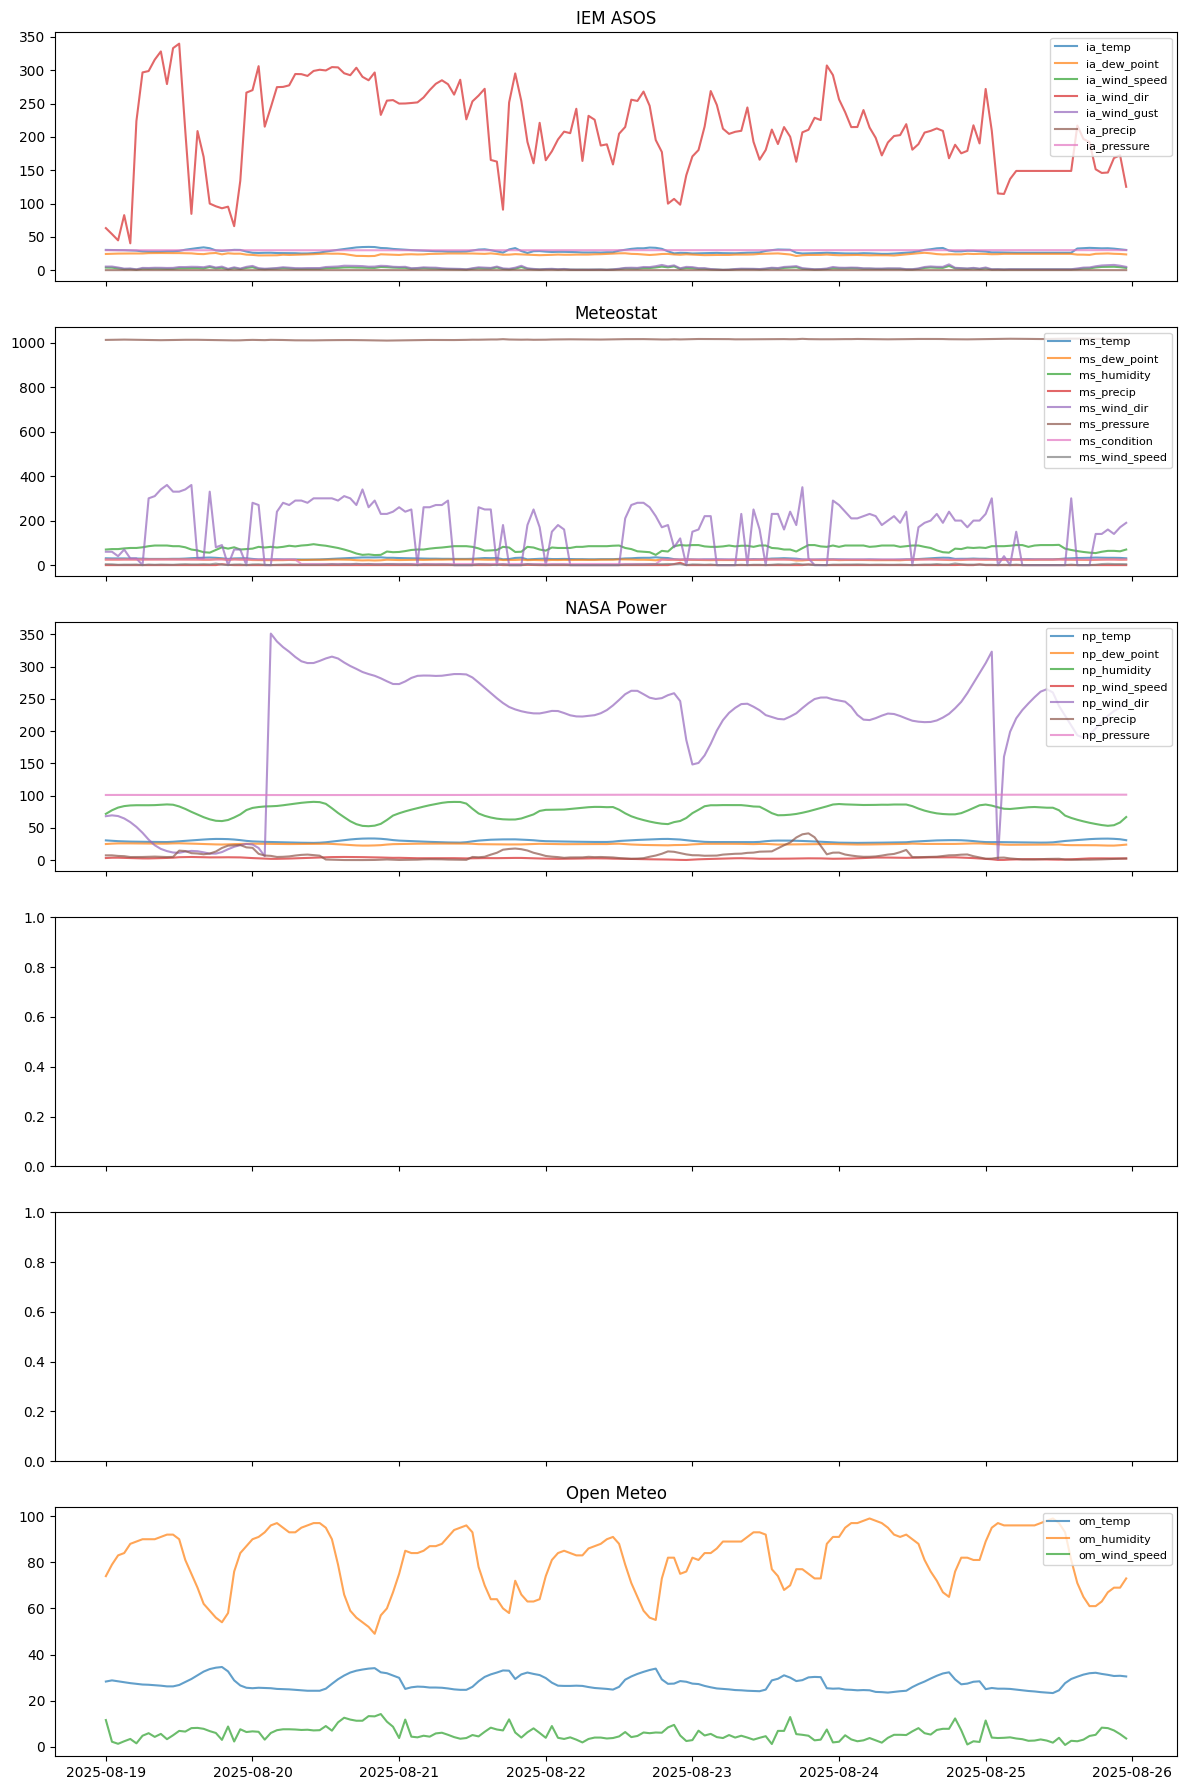

In [14]:
import matplotlib.dates as mdates

lookback_hours = 24 * 7
start_plot_idx = max(0, len(features_df) - lookback_hours)
plot_index = features_df.index[start_plot_idx:]
plot_df = features_df.iloc[start_plot_idx:]

prov_names = sorted(set(PROVIDER_PREFIX.values()))
fig, axes = plt.subplots(len(prov_names), 1, figsize=(12, 3*len(prov_names)), sharex=True)
if len(prov_names) == 1:
    axes = [axes]
prov_to_ax = dict(zip(prov_names, axes))

for col in plot_df.columns:
    pref = next((p for p in PROVIDER_PREFIX if col.startswith(p)), None)
    if pref is None: continue
    pname = PROVIDER_PREFIX[pref]
    ax = prov_to_ax[pname]
    ax.plot(plot_index, plot_df[col], label=col, alpha=0.7)
    ax.set_title(pname)
    ax.legend(loc='upper right', fontsize=8)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.tight_layout()
plt.show()


### Sample Input (30 days) vs Target (tomorrow TMAX)

In [15]:
# Take first test sample
if len(test_dataset) > 0:
    x_sample, y_sample = test_dataset[0]
    pos = midnight_positions_test[0]
    ts = index_arr[pos]
    input_index = index_arr[pos - SEQUENCE_LENGTH:pos]
    target_date = ts.normalize()
    target_value = target_daily.loc[target_date, TARGET_COLUMN]

    print(f"Sample prediction timestamp (midnight): {ts}")
    print(f"Target date: {target_date.date()} | Target TMAX: {target_value:.2f}")
    print("Input window (last 30 days) summary:")
    window_df = pd.DataFrame(x_sample.numpy(), index=input_index, columns=FEATURE_COLUMNS)
    display(window_df.tail())
else:
    print("No test samples available.")


Sample prediction timestamp (midnight): 2020-01-01 00:00:00
Target date: 2020-01-01 | Target TMAX: 41.00
Input window (last 30 days) summary:


,om_temp,om_humidity,om_wind_speed,np_temp,np_dew_point,np_humidity,np_wind_speed,np_wind_dir,np_precip,np_pressure,...,ia_precip,ia_pressure,ms_temp,ms_dew_point,ms_humidity,ms_precip,ms_wind_dir,ms_pressure,ms_condition,ms_wind_speed
2019-12-31 19:00:00,0.347963,0.092845,-0.665436,0.136638,-1.283466,-2.204940,-0.869935,2.059568,-0.399716,-0.223760,...,-0.107153,-0.282590,0.439543,-0.210959,-0.945827,-0.120653,1.475971,-0.253001,-0.751642,-0.418384
2019-12-31 20:00:00,0.422372,-0.423117,-0.723755,0.150404,-1.321256,-2.263497,-0.910819,2.101849,-0.399716,-0.223760,...,-0.107153,-0.292876,0.485190,-0.231002,-1.018960,-0.120653,1.762323,-0.307539,-0.751642,-0.186225
2019-12-31 21:00:00,0.447175,-0.570535,-0.796654,0.033387,-1.274574,-2.068880,-0.900598,2.145214,-0.399716,-0.146208,...,-0.107153,-0.271988,0.234133,-0.231002,-0.726429,-0.120653,1.571422,-0.334800,-0.751642,-0.186225
2019-12-31 22:00:00,0.199144,-0.128282,-0.869552,-0.393382,-1.185655,-1.410112,-0.788168,2.186411,-0.399716,-0.042799,...,-0.107153,-0.197314,0.120016,-0.431436,-0.872694,-0.120653,1.857774,-0.280278,-0.751642,-0.186225
2019-12-31 23:00:00,-0.371327,0.535098,-0.927871,-0.604472,-1.347932,-1.367916,-0.665517,-1.635161,-0.399716,0.086447,...,-0.107153,-0.057425,-0.153864,-0.551697,-0.726429,-0.120653,1.857774,-0.143942,-0.751642,-0.934292


## 4. Neural Network Architectures (core + extended)


In [16]:
class NaiveMeanRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.head = nn.Linear(input_dim, 1)
    def forward(self, x):
        x = x.mean(dim=1)
        return self.head(x)

class LastHourMLP(nn.Module):
    def __init__(self, input_dim, hidden=64):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(input_dim, hidden), nn.ReLU(), nn.Linear(hidden, 1))
    def forward(self, x):
        return self.mlp(x[:, -1, :])

class CNN1DRegressor(nn.Module):
    def __init__(self, input_dim, channels=32, kernel=5):
        super().__init__()
        self.conv = nn.Conv1d(input_dim, channels, kernel_size=kernel, padding=kernel//2)
        self.act = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(channels, 1)
    def forward(self, x):
        x = x.transpose(1,2)
        x = self.act(self.conv(x))
        x = self.pool(x).squeeze(-1)
        return self.head(x)

class GRURegressor(nn.Module):
    def __init__(self, input_dim, hidden=64, layers=1):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden, num_layers=layers, batch_first=True)
        self.head = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        return self.head(out[:, -1, :])

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1, output_dim=1):
        super().__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, SEQUENCE_LENGTH, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, output_dim)
    def forward(self, x):
        x = self.input_embedding(x) + self.pos_encoder
        x = self.transformer_encoder(x)
        x = x[:, -1, :]
        return self.output_layer(x)

# Transformer-esque variants
class TransformerDeeper(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dropout=0.1):
        super().__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, SEQUENCE_LENGTH, d_model))
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.head = nn.Linear(d_model, 1)
    def forward(self, x):
        x = self.input_embedding(x) + self.pos_encoder
        x = self.encoder(x)
        return self.head(x[:, -1, :])

class ConvTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, conv_kernel=5, dropout=0.1):
        super().__init__()
        self.conv = nn.Conv1d(input_dim, input_dim, kernel_size=conv_kernel, padding=conv_kernel//2)
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, SEQUENCE_LENGTH, d_model))
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.head = nn.Linear(d_model, 1)
    def forward(self, x):
        x = x.transpose(1,2)
        x = self.conv(x).transpose(1,2)
        x = self.input_embedding(x) + self.pos_encoder
        x = self.encoder(x)
        return self.head(x[:, -1, :])

class LocalWindowTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, window=168, dropout=0.1):
        super().__init__()
        self.window = window
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, window, d_model))
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.head = nn.Linear(d_model, 1)
    def forward(self, x):
        x = x[:, -self.window:, :]
        x = self.input_embedding(x) + self.pos_encoder
        x = self.encoder(x)
        return self.head(x[:, -1, :])

class MultiScaleTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, dropout=0.1):
        super().__init__()
        self.short_win = 24
        self.long_win = SEQUENCE_LENGTH
        self.emb = nn.Linear(input_dim, d_model)
        self.pos_short = nn.Parameter(torch.zeros(1, self.short_win, d_model))
        self.pos_long = nn.Parameter(torch.zeros(1, self.long_win, d_model))
        enc = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.enc_short = nn.TransformerEncoder(enc, num_layers=2)
        self.enc_long = nn.TransformerEncoder(enc, num_layers=2)
        self.head = nn.Linear(d_model*2, 1)
    def forward(self, x):
        x_short = self.emb(x[:, -self.short_win:, :]) + self.pos_short
        x_long = self.emb(x) + self.pos_long
        out_short = self.enc_short(x_short)[:, -1, :]
        out_long = self.enc_long(x_long)[:, -1, :]
        out = torch.cat([out_short, out_long], dim=-1)
        return self.head(out)

class GatedTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, SEQUENCE_LENGTH, d_model))
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.gate = nn.Sequential(nn.Linear(d_model, d_model), nn.Sigmoid())
        self.head = nn.Linear(d_model, 1)
    def forward(self, x):
        x = self.input_embedding(x) + self.pos_encoder
        x = self.encoder(x)
        g = self.gate(x[:, -1, :])
        out = x[:, -1, :] * g
        return self.head(out)

MODEL_BUILDERS = {
    'NaiveMean': lambda dim: NaiveMeanRegressor(dim),
    'LastHourMLP': lambda dim: LastHourMLP(dim),
    'CNN1D': lambda dim: CNN1DRegressor(dim),
    'GRU': lambda dim: GRURegressor(dim),
    'Transformer': lambda dim: TimeSeriesTransformer(dim),
    'TransformerDeeper': lambda dim: TransformerDeeper(dim),
    'ConvTransformer': lambda dim: ConvTransformer(dim),
    'LocalWindowTransformer': lambda dim: LocalWindowTransformer(dim),
    'MultiScaleTransformer': lambda dim: MultiScaleTransformer(dim),
    'GatedTransformer': lambda dim: GatedTransformer(dim),
}


### Extended sequence models (integrated from the research survey)

The original 10-model zoo now includes additional architectures from the survey section so everything trains from the same data pipeline. These models take the same `(batch, sequence_length, num_features)` tensors and return a single prediction per sample:
- `BaselineMLP` (flattened fully connected baseline)
- `BaselineLSTM` (stacked LSTM)
- `TransformerTmax` (encoder-only Transformer)
- `MMWSTM_ADRAN_Plus` (regime-switching + anomaly-aware hybrid)

`extreme_weather_loss` is provided for experiments that want to overweight tails, but the main training loop still uses the robust MAE + hard-penalty objective defined earlier.

In [17]:
import math
import torch.nn.functional as F

class BaselineMLP(nn.Module):
    def __init__(self, history_len, num_features, forecast_horizon=1, hidden_dims=(64, 64)):
        super().__init__()
        inp = history_len * num_features
        layers = []
        prev = inp
        for h in hidden_dims:
            layers += [nn.Linear(prev, h), nn.ReLU()]
            prev = h
        layers.append(nn.Linear(prev, forecast_horizon))
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        # Flatten the time dimension for a simple fully connected baseline
        return self.net(X.view(X.size(0), -1))


class BaselineLSTM(nn.Module):
    def __init__(self, num_features, hidden_size=64, num_layers=2, forecast_horizon=1, dropout=0.0, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(
            num_features,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional,
        )
        out_dim = hidden_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(out_dim, forecast_horizon)

    def forward(self, X):
        _, (h, _) = self.lstm(X)
        return self.fc(h[-1])


class TransformerTmax(nn.Module):
    def __init__(self, num_features, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1, forecast_horizon=1):
        super().__init__()
        self.input_proj = nn.Linear(num_features, d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, forecast_horizon)

    def forward(self, X):
        h = self.input_proj(X)
        h = self.encoder(h)
        return self.fc(h[:, -1, :])


class MMWSTMStream(nn.Module):
    def __init__(self, num_features, hidden_size=64, num_states=4):
        super().__init__()
        self.bilstm = nn.LSTM(num_features, hidden_size, num_layers=1, batch_first=True, bidirectional=True)
        self.state_proj = nn.Linear(2 * hidden_size, num_states)
        self.trans_matrix = nn.Parameter(torch.randn(num_states, num_states))

    def forward(self, X):
        h_seq, _ = self.bilstm(X)
        logits = self.state_proj(h_seq)
        probs = F.softmax(logits, dim=-1)
        pi0 = probs[:, 0, :]
        trans = F.softmax(self.trans_matrix, dim=-1)
        pi = pi0
        for _ in range(1, h_seq.size(1)):
            pi = pi @ trans
        last = h_seq[:, -1, :]
        return torch.cat([last, pi], dim=-1)


class ADRANStream(nn.Module):
    def __init__(self, num_features, hidden_size=64, num_heads=4):
        super().__init__()
        self.bigru = nn.GRU(num_features, hidden_size, num_layers=1, batch_first=True, bidirectional=True)
        self.attn = nn.MultiheadAttention(embed_dim=2 * hidden_size, num_heads=num_heads, batch_first=True)
        self.anomaly_amp = nn.Linear(2 * hidden_size, 2 * hidden_size)

    def forward(self, X):
        h_seq, _ = self.bigru(X)
        attn_out, _ = self.attn(h_seq, h_seq, h_seq)
        amp = torch.tanh(self.anomaly_amp(attn_out))
        return torch.max(amp, dim=1).values


class MMWSTM_ADRAN_Plus(nn.Module):
    def __init__(self, num_features, hidden_size=64, num_states=4, num_heads=4, forecast_horizon=1):
        super().__init__()
        self.mmwstm = MMWSTMStream(num_features, hidden_size, num_states)
        self.adran = ADRANStream(num_features, hidden_size, num_heads)
        fusion_in = (2 * hidden_size + num_states) + (2 * hidden_size)
        self.fusion_gate = nn.Linear(fusion_in, fusion_in)
        self.fc = nn.Linear(fusion_in, forecast_horizon)

    def forward(self, X):
        reg = self.mmwstm(X)
        anom = self.adran(X)
        z = torch.cat([reg, anom], dim=-1)
        gate = torch.sigmoid(self.fusion_gate(z))
        fused = gate * z
        return self.fc(fused)


def extreme_weather_loss(pred, target, lower_q=0.05, upper_q=0.95, base_weight=1.0, extreme_weight=5.0):
    y = target.view(-1)
    y_pred = pred.view(-1)
    ql = torch.quantile(y, lower_q)
    qh = torch.quantile(y, upper_q)
    base = (y_pred - y) ** 2
    mask = (y <= ql) | (y >= qh)
    w = torch.where(mask, torch.tensor(extreme_weight, device=y.device), torch.tensor(base_weight, device=y.device))
    return torch.mean(w * base)

class DNNM3(nn.Module):
    def __init__(self, input_dim, hidden_dims=(256, 256, 256, 256, 256), forecast_horizon=1):
        super().__init__()
        
        # Define the layers of the model
        layers = []
        prev_dim = input_dim
        
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())  # ReLU activation function
            prev_dim = h
        
        # Output layer for forecasting temperature
        self.fc_out = nn.Linear(prev_dim, forecast_horizon)
        
        # Apply layers as a sequential module
        self.net = nn.Sequential(*layers)

    def forward(self, X):
        # Pass the input through the layers
        hidden = self.net(X)
        # Output the forecasted temperature
        return self.fc_out(hidden)



MODEL_BUILDERS.update({
    'BaselineMLP': lambda dim: BaselineMLP(SEQUENCE_LENGTH, dim),
    'BaselineLSTM': lambda dim: BaselineLSTM(dim),
    'TransformerTmax': lambda dim: TransformerTmax(dim),
    'MMWSTM_ADRAN_Plus': lambda dim: MMWSTM_ADRAN_Plus(dim),
    'DNNM3': lambda dim: DNNM3(dim),
})


## 5. Training Loop (shared)

In [18]:
def batch_loss(pred, target):
    err_norm = pred - target
    mae_norm = torch.mean(torch.abs(err_norm))
    target_std_t = torch.tensor(target_std, device=pred.device, dtype=pred.dtype)
    err_deg = torch.abs(err_norm) * target_std_t
    hard_penalty = torch.clamp(err_deg - LOSS_MARGIN_DEG, min=0.0)
    hard_loss = hard_penalty.mean()
    total = mae_norm + LOSS_HARD_PENALTY * hard_loss
    return total, mae_norm, hard_loss


def update_metrics(err_deg, accum):
    n = err_deg.numel()
    accum['count'] += n
    accum['mae_sum'] += err_deg.sum().item()
    accum['sse_sum'] += (err_deg ** 2).sum().item()
    accum['max'] = max(accum['max'], err_deg.max().item())


def finalize_metrics(accum):
    mae = accum['mae_sum'] / max(accum['count'], 1)
    rmse = (accum['sse_sum'] / max(accum['count'], 1)) ** 0.5
    maxae = accum['max']
    return mae, rmse, maxae


def train_model(model, name):
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train_losses = []
    val_losses = []
    train_mae_hist = []
    val_mae_hist = []
    train_rmse_hist = []
    val_rmse_hist = []
    train_maxae_hist = []
    val_maxae_hist = []

    print(f"=== Training {name} ===")
    for epoch in range(NUM_EPOCHS):
        model.train()
        batch_losses = []
        train_accum = {'count': 0, 'mae_sum': 0.0, 'sse_sum': 0.0, 'max': 0.0}

        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            output = model(x).squeeze(1)
            total_loss, mae_norm, hard_loss = batch_loss(output, y)
            total_loss.backward()
            optimizer.step()
            batch_losses.append(total_loss.item())

            target_std_t = torch.tensor(target_std, device=output.device, dtype=output.dtype)
            err_deg = torch.abs(output - y) * target_std_t
            update_metrics(err_deg, train_accum)

        avg_train_loss = np.mean(batch_losses)
        train_losses.append(avg_train_loss)
        t_mae, t_rmse, t_maxae = finalize_metrics(train_accum)
        train_mae_hist.append(t_mae)
        train_rmse_hist.append(t_rmse)
        train_maxae_hist.append(t_maxae)

        model.eval()
        val_batch_losses = []
        val_accum = {'count': 0, 'mae_sum': 0.0, 'sse_sum': 0.0, 'max': 0.0}
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                output = model(x).squeeze(1)
                total_loss, mae_norm, hard_loss = batch_loss(output, y)
                val_batch_losses.append(total_loss.item())
                target_std_t = torch.tensor(target_std, device=output.device, dtype=output.dtype)
                err_deg = torch.abs(output - y) * target_std_t
                update_metrics(err_deg, val_accum)

        avg_val_loss = np.mean(val_batch_losses)
        val_losses.append(avg_val_loss)
        v_mae, v_rmse, v_maxae = finalize_metrics(val_accum)
        val_mae_hist.append(v_mae)
        val_rmse_hist.append(v_rmse)
        val_maxae_hist.append(v_maxae)

        print(
            f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
            f"Train MAE: {t_mae:.3f}° | Val MAE: {v_mae:.3f}° | "
            f"Train RMSE: {t_rmse:.3f}° | Val RMSE: {v_rmse:.3f}° | "
            f"Train MaxAE: {t_maxae:.3f}° | Val MaxAE: {v_maxae:.3f}°"
        )

    return {
        'model': model,
        'name': name,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_mae': train_mae_hist,
        'val_mae': val_mae_hist,
        'train_rmse': train_rmse_hist,
        'val_rmse': val_rmse_hist,
        'train_maxae': train_maxae_hist,
        'val_maxae': val_maxae_hist,
    }

### Train All Models

Runs every entry in `MODEL_BUILDERS` (original 10 plus the 4 extended models). Increase `NUM_EPOCHS` or drop entries from `MODEL_BUILDERS` if you need a faster pass.

In [19]:
results = []
for name, builder in MODEL_BUILDERS.items():
    model = builder(len(FEATURE_COLUMNS))
    res = train_model(model, name)
    results.append(res) 

=== Training NaiveMean ===
Epoch [1/30] Train Loss: 23.5840 | Val Loss: 21.2381 | Train MAE: 11.977° | Val MAE: 10.847° | Train RMSE: 14.608° | Val RMSE: 13.189° | Train MaxAE: 48.427° | Val MaxAE: 45.429°
Epoch [2/30] Train Loss: 21.6500 | Val Loss: 19.6067 | Train MAE: 11.026° | Val MAE: 10.041° | Train RMSE: 13.587° | Val RMSE: 12.303° | Train MaxAE: 47.596° | Val MaxAE: 44.883°
Epoch [3/30] Train Loss: 20.4731 | Val Loss: 18.4414 | Train MAE: 10.407° | Val MAE: 9.462° | Train RMSE: 12.909° | Val RMSE: 11.679° | Train MaxAE: 46.847° | Val MaxAE: 44.328°
Epoch [4/30] Train Loss: 19.5783 | Val Loss: 17.6354 | Train MAE: 9.987° | Val MAE: 9.056° | Train RMSE: 12.455° | Val RMSE: 11.230° | Train MaxAE: 46.149° | Val MaxAE: 43.774°
Epoch [5/30] Train Loss: 18.8753 | Val Loss: 17.0546 | Train MAE: 9.680° | Val MAE: 8.769° | Train RMSE: 12.126° | Val RMSE: 10.890° | Train MaxAE: 45.925° | Val MaxAE: 43.275°
Epoch [6/30] Train Loss: 18.4384 | Val Loss: 16.5779 | Train MAE: 9.445° | Val MAE:

## 6. Evaluation

Validation metrics:


,model,Val MAE,Val RMSE,Val MaxAE
0,NaiveMean,6.862525,8.719329,35.679962
1,LastHourMLP,7.544618,9.562899,34.950890
2,CNN1D,6.814075,8.863443,32.021805
3,GRU,6.303056,8.034456,28.508713
4,Transformer,6.843829,8.759922,31.004534
5,TransformerDeeper,7.315036,9.392876,38.569626
6,ConvTransformer,6.904170,8.821059,32.806171
7,LocalWindowTransformer,6.599120,8.416903,28.294033
8,MultiScaleTransformer,6.601930,8.299138,29.680597
9,GatedTransformer,6.867006,8.719311,29.906050


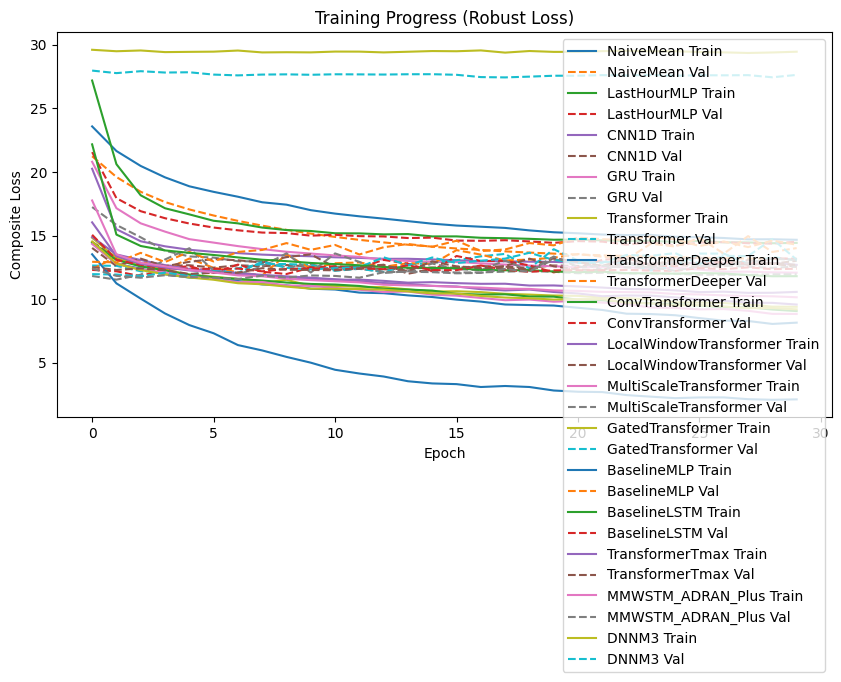

Best model: GRU (Val MAE=6.303°)
Test MAE: 6.303°, RMSE: 8.034°, MaxAE: 28.509°


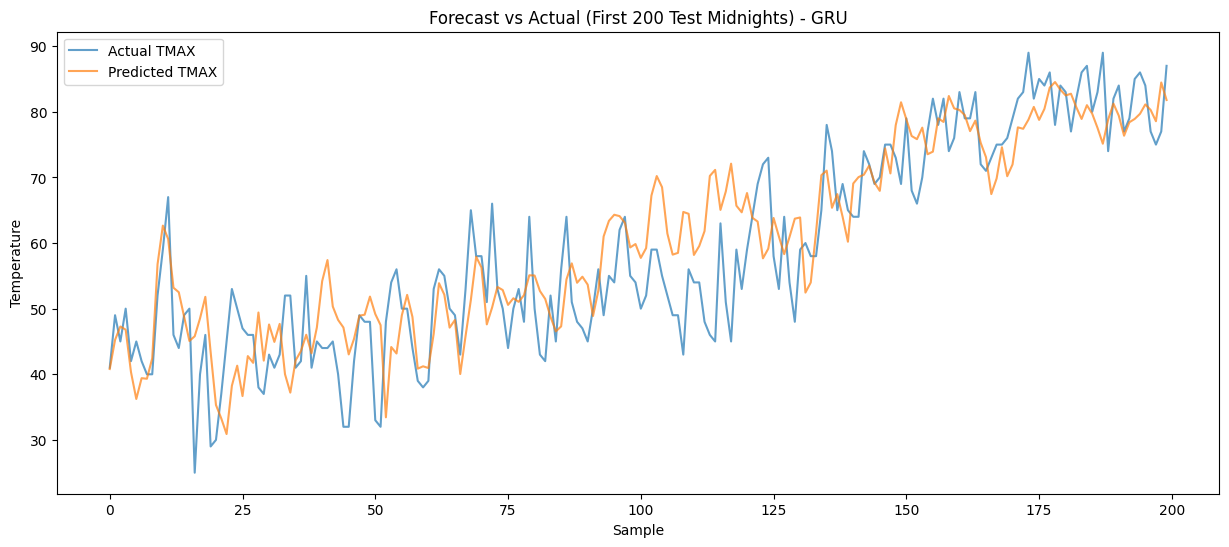

Sample predictions (midnight targets, best model):


,model,actual_TMAX,pred_TMAX,abs_error
0,GRU,41.0,40.802410,0.197590
1,GRU,49.0,45.239315,3.760685
2,GRU,45.0,47.282318,2.282318
3,GRU,50.0,46.798012,3.201988
4,GRU,42.0,40.335812,1.664188
5,GRU,45.0,36.236160,8.763840
6,GRU,42.0,39.404366,2.595634
7,GRU,40.0,39.321487,0.678513
8,GRU,40.0,42.436882,2.436882
9,GRU,52.0,56.756672,4.756672


In [20]:
# Summaries
table_rows = []
for res in results:
    mae = res['val_mae'][-1]
    rmse = res['val_rmse'][-1]
    maxae = res['val_maxae'][-1]
    table_rows.append({'model': res['name'], 'Val MAE': mae, 'Val RMSE': rmse, 'Val MaxAE': maxae})

summary_df = pd.DataFrame(table_rows)
print("Validation metrics:")
display(summary_df)

# Plot losses for all models
plt.figure(figsize=(10,5))
for res in results:
    plt.plot(res['train_losses'], label=f"{res['name']} Train")
    plt.plot(res['val_losses'], linestyle='--', label=f"{res['name']} Val")
plt.title('Training Progress (Robust Loss)')
plt.xlabel('Epoch')
plt.ylabel('Composite Loss')
plt.legend()
plt.show()

# Choose best model by Val MAE
best_res = min(results, key=lambda r: r['val_mae'][-1])
best_model = best_res['model']
print(f"Best model: {best_res['name']} (Val MAE={best_res['val_mae'][-1]:.3f}°)")

# Evaluate best model on test set
best_model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        output = best_model(x).squeeze(1)
        predictions.extend(output.cpu().numpy())
        actuals.extend(y.numpy())

pred_denorm = [denormalize_target(p) for p in predictions]
actual_denorm = [denormalize_target(a) for a in actuals]
err = np.abs(np.array(pred_denorm) - np.array(actual_denorm))
mae_final = err.mean()
rmse_final = (np.square(err).mean()) ** 0.5
maxae_final = err.max()
print(f"Test MAE: {mae_final:.3f}°, RMSE: {rmse_final:.3f}°, MaxAE: {maxae_final:.3f}°")

tmax_plot_len = min(200, len(actual_denorm))
plt.figure(figsize=(15, 6))
plt.plot(actual_denorm[:tmax_plot_len], label='Actual TMAX', alpha=0.7)
plt.plot(pred_denorm[:tmax_plot_len], label='Predicted TMAX', alpha=0.7)
plt.title(f"Forecast vs Actual (First {tmax_plot_len} Test Midnights) - {best_res['name']}")
plt.xlabel('Sample')
plt.ylabel('Temperature')
plt.legend()
plt.show()

sample_n = min(20, len(actual_denorm))
pred_df = pd.DataFrame({
    'model': best_res['name'],
    'actual_TMAX': actual_denorm[:sample_n],
    'pred_TMAX': pred_denorm[:sample_n],
    'abs_error': err[:sample_n]
})
print("Sample predictions (midnight targets, best model):")
display(pred_df)


### Optional graph / NWP models (not executed by default)

These architectures target multi-station graphs, NWP grid patches, or physics-informed post-processing. They share the same library imports and can be used with additional data (e.g., adjacency matrices, NWP grids) while reusing the preprocessing and normalization above. They are defined here so the notebook is cohesive but remain optional to keep the main training loop lightweight.

In [21]:
import math
import torch.nn.functional as F


class CNNTmaxPostProcessor(nn.Module):
    def __init__(self, nwp_channels, grid_H, grid_W, hidden_dim=64, output_bias=True):
        super().__init__()
        self.output_bias = output_bias
        self.conv = nn.Sequential(
            nn.Conv2d(nwp_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        conv_out = 64 * (grid_H // 4) * (grid_W // 4)
        self.fc = nn.Sequential(nn.Linear(conv_out, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1))

    def forward(self, X_nwp, raw_nwp_tmax=None):
        z = self.conv(X_nwp)
        z = z.view(z.size(0), -1)
        delta = self.fc(z)
        return raw_nwp_tmax + delta if self.output_bias and raw_nwp_tmax is not None else delta


class SimpleGraphConv(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Linear(in_dim, out_dim, bias=False)

    def forward(self, X, A):
        N = A.size(0)
        I = torch.eye(N, device=A.device)
        A_hat = A + I
        D_hat = torch.sum(A_hat, dim=1)
        D_inv_sqrt = torch.diag(torch.pow(D_hat + 1e-8, -0.5))
        A_norm = D_inv_sqrt @ A_hat @ D_inv_sqrt
        return F.relu(torch.einsum('ij,bjd->bid', A_norm, self.W(X)))


class WeatherGNN(nn.Module):
    def __init__(self, num_features, hidden_dim=64, num_layers=2):
        super().__init__()
        layers = []
        in_dim = num_features
        for _ in range(num_layers):
            layers.append(SimpleGraphConv(in_dim, hidden_dim))
            in_dim = hidden_dim
        self.layers = nn.ModuleList(layers)
        self.readout = nn.Linear(hidden_dim, 1)

    def forward(self, X, A):
        h = X
        for layer in self.layers:
            h = layer(h, A)
        return self.readout(h)


def physics_constrained_loss(pred_tmax, true_tmax, tmin=None, clim_max=None, base_loss_weight=1.0, constraint_weight=1.0):
    base = F.mse_loss(pred_tmax, true_tmax)
    penalties = 0.0
    if tmin is not None:
        penalties = penalties + torch.mean(F.relu(tmin - pred_tmax))
    if clim_max is not None:
        penalties = penalties + torch.mean(F.relu(pred_tmax - clim_max))
    return base_loss_weight * base + constraint_weight * penalties


class SpatialAttention(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.query = nn.Linear(in_dim, hidden_dim)
        self.key = nn.Linear(in_dim, hidden_dim)
        self.value = nn.Linear(in_dim, hidden_dim)

    def forward(self, X):
        Q = self.query(X)
        K = self.key(X)
        V = self.value(X)
        scores = torch.einsum('bnd,bmd->bnm', Q, K) / math.sqrt(Q.size(-1))
        attn = F.softmax(scores, dim=-1)
        return torch.einsum('bnm,bmd->bnd', attn, V)


class TemporalAttention(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.query = nn.Linear(in_dim, hidden_dim)
        self.key = nn.Linear(in_dim, hidden_dim)
        self.value = nn.Linear(in_dim, hidden_dim)

    def forward(self, X):
        Q = self.query(X)
        K = self.key(X)
        V = self.value(X)
        scores = torch.einsum('btd,bsd->bts', Q, K) / math.sqrt(Q.size(-1))
        attn = F.softmax(scores, dim=-1)
        out = torch.einsum('bts,bsd->btd', attn, V)
        return out.mean(dim=1)


class GRASTStyleSTGNN(nn.Module):
    def __init__(self, num_features, hidden_dim=64, forecast_horizon=1):
        super().__init__()
        self.node_embed = nn.Linear(num_features, hidden_dim)
        self.spatial_att = SpatialAttention(hidden_dim, hidden_dim)
        self.temporal_att = TemporalAttention(hidden_dim, hidden_dim)
        self.readout = nn.Linear(hidden_dim, forecast_horizon)

    def forward(self, X):
        B, T, N, F_in = X.shape
        h = self.node_embed(X.view(B * T, N, F_in))
        h = self.spatial_att(h)
        h_spatial = h.mean(dim=1).view(B, T, -1)
        h_temp = self.temporal_att(h_spatial)
        return self.readout(h_temp)


class TemporalConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, dilation=1):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=(kernel_size, 1),
            dilation=(dilation, 1),
            padding=(dilation * (kernel_size - 1), 0),
        )

    def forward(self, X):
        return self.conv(X)[:, :, : X.size(2), :]


class GraphWaveNetLite(nn.Module):
    def __init__(self, num_features, num_nodes, temporal_channels=32, gcn_hidden=32, forecast_horizon=1):
        super().__init__()
        self.input_proj = nn.Conv2d(num_features, temporal_channels, kernel_size=(1, 1))
        self.tconv1 = TemporalConvBlock(temporal_channels, temporal_channels, dilation=1)
        self.tconv2 = TemporalConvBlock(temporal_channels, temporal_channels, dilation=2)
        self.gcn1 = SimpleGraphConv(temporal_channels, gcn_hidden)
        self.gcn2 = SimpleGraphConv(gcn_hidden, gcn_hidden)
        self.readout = nn.Linear(gcn_hidden, forecast_horizon)

    def forward(self, X, A):
        B, T, N, F_in = X.shape
        X_proj = X.permute(0, 3, 1, 2)
        h = self.input_proj(X_proj)
        h = F.relu(self.tconv1(h))
        h = F.relu(self.tconv2(h))
        h_time = h.mean(dim=2)
        h_nodes = h_time.permute(0, 2, 1)
        h_nodes = self.gcn1(h_nodes, A)
        h_nodes = self.gcn2(h_nodes, A)
        return self.readout(h_nodes)


class AttnGNNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.W = nn.Linear(in_dim, out_dim, bias=False)
        self.a = nn.Linear(2 * out_dim, 1)

    def forward(self, X, A):
        H = self.W(X)
        B, N, D = H.shape
        H_i = H.unsqueeze(2).repeat(1, 1, N, 1)
        H_j = H.unsqueeze(1).repeat(1, N, 1, 1)
        cat = torch.cat([H_i, H_j], dim=-1)
        e = F.leaky_relu(self.a(cat)).squeeze(-1)
        mask = (A > 0).unsqueeze(0)
        e = e.masked_fill(~mask, float('-inf'))
        alpha = F.softmax(e, dim=-1)
        return F.relu(torch.einsum('bij,bjd->bid', alpha, H))


class IntegratedGNNPostProcessor(nn.Module):
    def __init__(self, num_features, hidden_dim=64, num_layers=2):
        super().__init__()
        layers = []
        in_dim = num_features
        for _ in range(num_layers):
            layers.append(AttnGNNLayer(in_dim, hidden_dim))
            in_dim = hidden_dim
        self.layers = nn.ModuleList(layers)
        self.readout = nn.Linear(hidden_dim, 1)

    def forward(self, X, A):
        h = X
        for layer in self.layers:
            h = layer(h, A)
        return self.readout(h)
